       track_popularity  danceability  energy  key  loudness  mode  \
82                   71         0.362   0.921    1    -3.815     0   
181                  42         0.630   0.731    6    -4.985     1   
188                  46         0.772   0.687    9    -6.348     0   
212                  79         0.747   0.776   10    -5.898     0   
249                  56         0.502   0.780    0    -4.547     1   
...                 ...           ...     ...  ...       ...   ...   
32801                39         0.769   0.977    7    -2.703     1   
32805                27         0.671   0.971    5    -4.518     0   
32807                52         0.599   0.763    3    -3.727     0   
32819                10         0.624   0.735    2    -6.664     1   
32832                27         0.603   0.884    5    -4.571     0   

       speechiness  acousticness  instrumentalness  liveness  valence  \
82          0.4860      0.123000          0.000000    0.1900   0.5290   
181         0

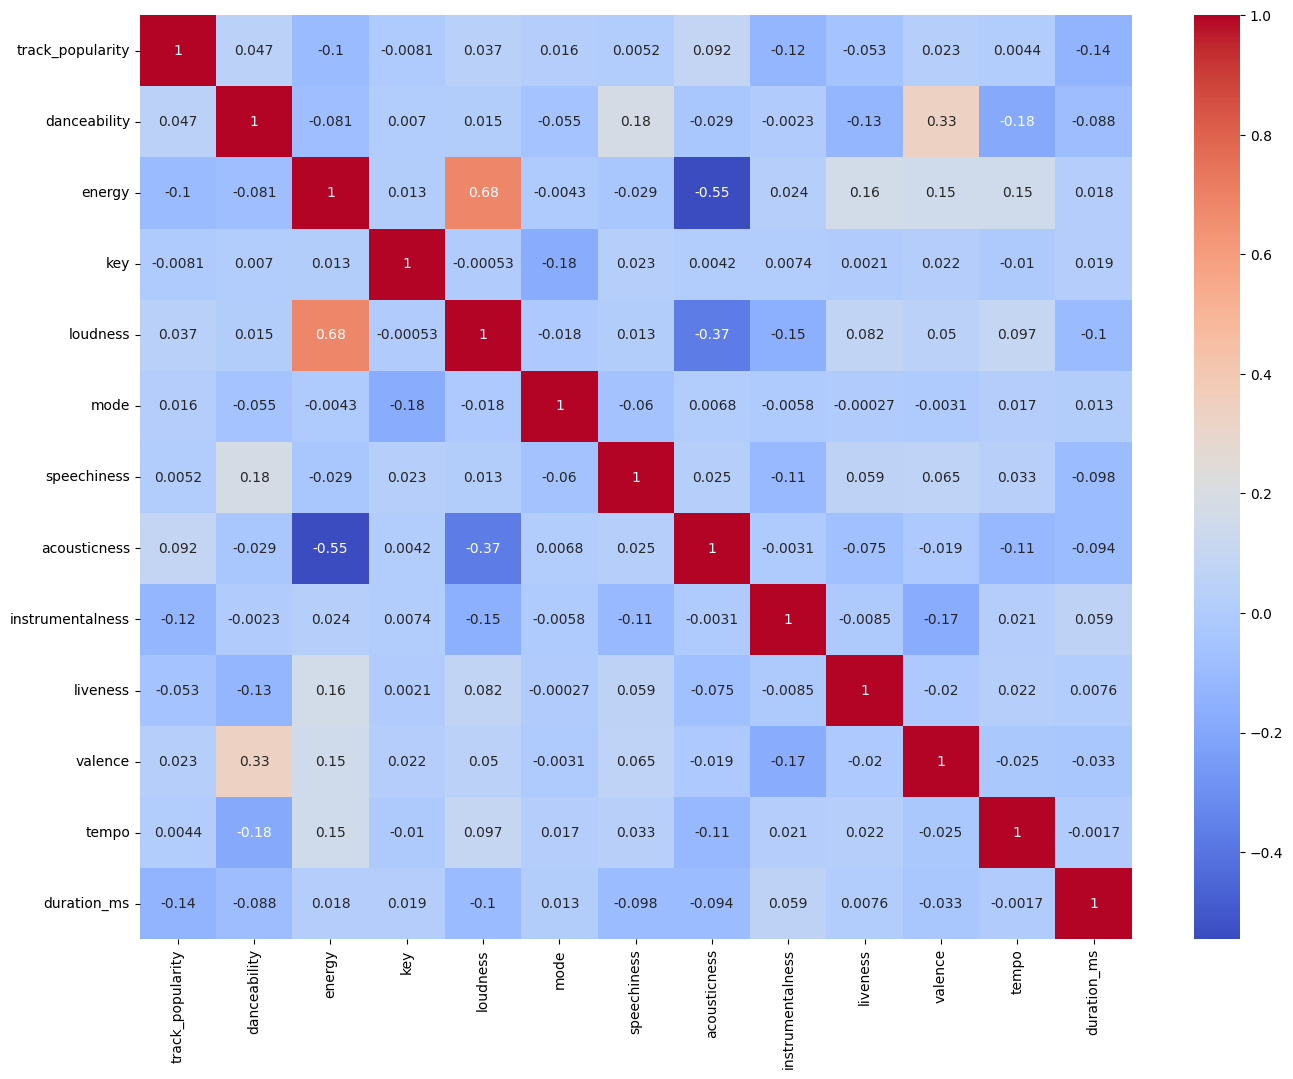

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from scipy import stats

# Load the dataset
file_path = './datasets/spotify_songs.csv'
data = pd.read_csv(file_path, encoding='ISO-8859-1')
data = data.drop_duplicates(subset='track_id')

# Step 1: Remove specified columns
# columns_to_exclude = ['track_name', 'artist(s)_name'] + [col for col in data.columns if col.startswith('in_')]
columns_to_exclude = [col for col in data.columns if col.startswith('track_') and col != 'track_popularity'] + [col for col in data.columns if col.startswith('playlist_')]
data_selected = data.drop(columns=columns_to_exclude)

# Calculate Z-scores
z_scores = stats.zscore(data_selected)

# Find outliers
outliers = (np.abs(z_scores) > 3).any(axis=1)

# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

numerical_cols = data_selected.drop('track_popularity', axis=1).columns.values

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # OneHotEncoding for categorical features
    ('imputer', IterativeImputer(random_state=42))  # Impute missing values with the median
])

# Separate features and target variable
X = data_selected.drop('track_popularity', axis=1)
y = data_selected['track_popularity']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

# RF
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train_transformed, y_train)
y_pred_rf = rf_regressor.predict(X_test_transformed)

feature_importances = rf_regressor.feature_importances_
for name, importance in zip(numerical_cols, feature_importances):
    print(f"Feature: {name}, Importance: {importance}")

# SVR
svr = SVR(kernel='linear')
svr.fit(X_train_transformed, y_train)
y_pred_svr = svr.predict(X_test_transformed)

# LR
pr = PolynomialFeatures(degree=2)
X_poly = pr.fit_transform(X_train_transformed)

lr = LinearRegression()
lr.fit(X_poly, y_train)
X_poly_test = pr.fit_transform(X_test_transformed)

y_pred_poly = lr.predict(X_poly_test)

# Ridge
ridge = Ridge(alpha=1)
ridge.fit(X_train_transformed, y_train)
y_pred_ridge = ridge.predict(X_test_transformed)

# Lasso Regression
lasso = Lasso(alpha=1.0)
lasso.fit(X_train_transformed, y_train)
y_pred_lasso = lasso.predict(X_test_transformed)

# Multilayer Perceptron
# mlp = MLPRegressor(hidden_layer_sizes=(30,50,50), activation='relu', solver='adam', max_iter=10000, random_state=42, learning_rate='adaptive')
# mlp.fit(X_train_transformed, y_train)
# y_pred_mlp = mlp.predict(X_test_transformed)

print(f"MAPE for RF: {mean_absolute_percentage_error(y_test, y_pred_rf)}")
print(f"MAPE for SVR: {mean_absolute_percentage_error(y_test, y_pred_svr)}")
print(f"MAPE for POLY: {mean_absolute_percentage_error(y_test, y_pred_poly)}")
print(f"MAPE for Ridge: {mean_absolute_percentage_error(y_test, y_pred_ridge)}")
print(f"MAPE for Lasso: {mean_absolute_percentage_error(y_test, y_pred_lasso)}")
# print(f"MAPE for MLP: {mean_absolute_percentage_error(y_test, y_pred_mlp)}")
print("Mean of y_train: {:.2e}".format(np.mean(y_train)))
print("Median of y_train: {:.2e}".format(np.median(y_train)))

correlation_matrix = data_selected.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()
